## Project 2

Scraping Data from Websites

In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import unicodedata
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


_____
### State ranking data

In [2]:
import requests

url = 'https://wallethub.com/edu/states-with-the-best-schools/5335/'

response = requests.get(url)

In [3]:
page = response.text

In [4]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(page,"lxml")

In [5]:
rank_dict = {}

for i in range(51):
    rank = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[5*i].text
    state = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[1+5*i].text
    state = state.replace(' ','')
    score = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[2+5*i].text
    quality = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[3+5*i].text
    safety = soup.find(class_='cardhub-edu-table center-aligned sortable').find_all('td')[4+5*i].text
    rank_dict[rank] = [state,float(score),int(quality),int(safety)]

In [6]:
df_rank = pd.DataFrame.from_dict(rank_dict, orient='index', dtype=None)
df_rank.rename(index=str, columns={0: 'State', 1: 'Overall_score',2:'Quality_rank', 
                                   3:'Safety_rank'}, inplace = True)

##### State Rank data frame

In [7]:
df_rank.sample(5)

,State,Overall_score,Quality_rank,Safety_rank
30,Nebraska,51.22,12,44
11,Illinois,58.32,9,21
50,NewMexico,34.79,51,40
45,Alaska,38.20,47,43
10,Maine,59.93,16,4


____
### State budget data

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._state_budgets'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [9]:
budget_dict = {}

for i in range(50):
    state = soup.find(class_='mw-parser-output').find_all('td')[6*i].text
    state = state.replace(' ','')
    
    budget = soup.find(class_='mw-parser-output').find_all('td')[1+6*i].text
    budget = float(budget)
    
    fy = soup.find(class_='mw-parser-output').find_all('td')[2+6*i].text
    loc = fy.find('–')
    if fy.find('–') != -1:
        front = int(fy[:loc])
        back = int('20' + fy[loc+1:])
        years = back - front + 1
    else: 
        back = int(fy)
        years = 1
    
    budget_per_capita = soup.find(class_='mw-parser-output').find_all('td')[4+6*i].text
    budget_per_capita = int(budget_per_capita.replace(',',''))
    
    credit_rating = soup.find(class_='mw-parser-output').find_all('td')[5+6*i].text
    
    budget_dict[state] = [budget,back,years,budget_per_capita,credit_rating]

In [10]:
df_budget = pd.DataFrame.from_dict(budget_dict, orient='index', dtype=None)
df_budget.rename(index=str, columns={0: 'Budget_billion', 1: 'Year_end',2:'No_years', 3:'Per_capita',
                                     4:'Credit_rating'}, inplace = True)

In [11]:
df_budget = df_budget.reset_index(level=0)
df_budget.rename(columns = {'index' : 'State'}, inplace = True)

##### State Budget data drame

In [12]:
df_budget.sample(5)

,State,Budget_billion,Year_end,No_years,Per_capita,Credit_rating
24,Missouri,27.4,2017,1,4504,AAA
30,NewMexico,18.4,2017,1,8824,AA+
4,California,170.9,2017,2,4366,AA-
34,Ohio,65.7,2017,1,5657,AA+
9,Georgia,23.7,2017,1,2320,AAA


____
### Teacher salary data

In [13]:
from urllib.request import Request, urlopen

site= "https://articles.niche.com/teacher-salaries-in-america/"
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)
soup = BeautifulSoup(page,'lxml')

In [14]:
salary_dict = {}

for i in range(50):
    state = soup.find(class_='table-wrap ').find_all('td')[3*i].text
    state = state.replace('\n','').replace('State','').replace(' ','')
    
    start_salary = soup.find(class_='table-wrap ').find_all('td')[3*i + 1].text
    start_salary = int(start_salary.replace('\n','').replace('Average Starting Salary','')
                       .replace(',','').replace('$',''))
    
    salary = soup.find(class_='table-wrap ').find_all('td')[3*i + 2].text
    salary = int(salary.replace('\n','').replace('Average Salary','').replace(',','').replace('$',''))
    
    salary_dict[state] = [start_salary, salary]

In [15]:
df_salary = pd.DataFrame.from_dict(salary_dict, orient='index', dtype=None)
df_salary.rename(index=str, columns={0: 'Starting_salary', 1: 'Salary'}, inplace = True)

In [16]:
df_salary = df_salary.reset_index(level=0)
df_salary.rename(columns = {'index' : 'State'}, inplace = True)

##### Teacher Salary data frame

In [17]:
df_salary.sample(5)

,State,Starting_salary,Salary
36,Oklahoma,31919,45245
13,Illinois,38820,61602
24,Mississippi,34780,42925
21,Massachusetts,44726,77804
20,Maryland,44675,66961


___
### Medium Income

In [18]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_by_income'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [19]:
income_dict = {}

for i in range(54):
    rank = soup.find(class_='mw-parser-output').find_all('td')[6+7*i].text
    if rank:
        state = soup.find(class_='mw-parser-output').find_all('td')[7+7*i].text
        state = state.replace(' ','')
        income = soup.find(class_='mw-parser-output').find_all('td')[8+7*i].text
        income = int(income.replace(',','').replace('$',''))
        income_dict[rank] = [state, income]
    

In [20]:
df_income = pd.DataFrame.from_dict(income_dict, orient='index', dtype=None)
df_income.rename(index=str, columns={0: 'State', 1: 'Income'}, inplace = True)

##### Income data frame

In [21]:
df_income.sample(5)

,State,Income
24,Nebraska,54996
8,Virginia,66262
18,Illinois,59588
46,Kentucky,45215
14,Delaware,61255


___ 
### Class Size

In [22]:
url = 'https://nces.ed.gov/surveys/sass/tables/sass1112_2013314_t1s_007.asp'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [23]:
class_size_dict = {}

for i in range(60):
    warning = ''
    state = soup.find('tbody').find_all('th')[2+i].text
    state = state.replace('\r','').replace('\n','').replace(' ','')
    state = state.strip()
    if state: # ignores blank cells
        
        # Primary School
        PS_selfcont = soup.find('tbody').find_all('td')[32+16*i].text
        if PS_selfcont == '‡': PS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[33+16*i].text
        if warning == '!': PS_selfcont = '0'
        PS_selfcont = float(PS_selfcont)
        
        PS_dep = soup.find('tbody').find_all('td')[34+16*i].text
        if PS_dep == '‡': PS_dep = '0'
        warning = soup.find('tbody').find_all('td')[35+16*i].text
        if warning =='!': PS_dep = '0'
        PS_dep = float(PS_dep)
        
        # Middle School
        MS_selfcont = soup.find('tbody').find_all('td')[36+16*i].text
        if MS_selfcont == '‡': MS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[37+16*i].text
        if warning == '!': MS_selfcont = '0'
        MS_selfcont = float(MS_selfcont)
        
        MS_dep = soup.find('tbody').find_all('td')[38+16*i].text
        if MS_dep == '‡': MS_dep = '0'
        warning = soup.find('tbody').find_all('td')[39+16*i].text
        if warning == '!': MS_dep = '0'
        MS_dep = float(MS_dep)
        
        # High School
        HS_selfcont = soup.find('tbody').find_all('td')[40+16*i].text
        if HS_selfcont == '‡': HS_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[41+16*i].text
        if warning == '!': HS_selfcont = '0'
        HS_selfcont = float(HS_selfcont)
        
        HS_dep = soup.find('tbody').find_all('td')[42+16*i].text
        if HS_dep == '‡': HS_dep = '0'
        warning = soup.find('tbody').find_all('td')[43+16*i].text
        if warning == '!': HS_dep = '0'
        HS_dep = float(HS_dep)
        
        # Combined Grades
        CG_selfcont = soup.find('tbody').find_all('td')[44+16*i].text
        if CG_selfcont == '‡': CG_selfcont = '0'
        warning = soup.find('tbody').find_all('td')[45+16*i].text
        if warning == '!': CG_selfcont = '0'
        CG_selfcont = float(CG_selfcont)
        
        CG_dep = soup.find('tbody').find_all('td')[46+16*i].text
        if CG_dep == '‡': CG_dep = '0'
        warning = soup.find('tbody').find_all('td')[47+16*i].text
        if warning == '!': CG_dep = '0'
        CG_dep = float(CG_dep)

        class_size_dict[state] = [PS_selfcont, PS_dep, MS_selfcont, MS_dep, HS_selfcont, HS_dep, 
                                  CG_selfcont, CG_dep]

In [24]:
df_class_size = pd.DataFrame.from_dict(class_size_dict, orient='index', dtype=None)
df_class_size.rename(index=str, columns={0: 'Primary_SCC', 1: 'Primary_DI',2:'Middle_SCC',
                                         3:'Middle_DI',4:'High_SCC',5:'High_DI',6:'Combine_SCC',
                                         7:'Combine_DI'}, inplace = True)
df_class_size = df_class_size.reset_index(level=0)
df_class_size.rename(columns = {'index' : 'State'}, inplace = True)

##### Class Size Data Frame

In [25]:
df_class_size.sample(5)

,State,Primary_SCC,Primary_DI,Middle_SCC,Middle_DI,High_SCC,High_DI,Combine_SCC,Combine_DI
50,Wyoming,17.4,0.0,11.9,21.3,8.5,17.8,13.4,12.9
19,Maine,17.8,0.0,12.3,21.6,16.1,16.7,9.5,13.4
45,Vermont,16.7,19.3,16.8,20.9,12.7,17.7,14.2,10.9
15,Iowa,20.9,21.5,15.6,27.8,12.2,22.8,16.0,21.0
14,Indiana,21.7,35.1,18.3,25.8,14.4,23.6,17.0,18.9


____ 

### Education budget, itemized

In [26]:
money = {
      "State": [
        "Utah",
        "Idaho",
        "Arizona",
        "Oklahoma",
        "Mississippi",
        "Nevada",
        "North Carolina",
        "Texas",
        "Tennessee",
        "Florida",
        "South Dakota",
        "Colorado",
        "Alabama",
        "Georgia",
        "Kentucky",
        "Indiana",
        "California",
        "Arkansas",
        "South Carolina",
        "New Mexico",
        "Missouri",
        "Oregon",
        "Kansas",
        "Washington",
        "Iowa",
        "Louisiana",
        "Virginia",
        "U.S. Total",
        "Montana",
        "Michigan",
        "Wisconsin",
        "West Virginia",
        "Ohio",
        "Minnesota",
        "Nebraska",
        "North Dakota",
        "Hawaii",
        "Maine",
        "Illinois",
        "Delaware",
        "Pennsylvania",
        "Maryland",
        "New Hampshire",
        "Rhode Island",
        "Massachusetts",
        "Wyoming",
        "Vermont",
        "Connecticut",
        "New Jersey",
        "Alaska",
        "District of Columbia",
        "New York"],
      "Instruction_Employee_Salaries": [
        "2,562",
        "2,741",
        "2,855",
        "2,883",
        "3,098",
        "3,180",
        "3,609",
        "3,934",
        "3,555",
        "3,214",
        "3,592",
        "3,620",
        "3,359",
        "3,785",
        "3,747",
        "3,516",
        "3,779",
        "3,631",
        "3,737",
        "3,595",
        "4,096",
        "3,350",
        "3,833",
        "3,958",
        "4,508",
        "3,789",
        "4,580",
        "4,378",
        "4,243",
        "3,857",
        "4,310",
        "3,862",
        "4,435",
        "5,085",
        "4,938",
        "5,073",
        "4,711",
        "5,050",
        "4,747",
        "5,374",
        "5,368",
        "5,544",
        "5,673",
        "5,961",
        "6,343",
        "6,094",
        "6,564",
        "6,997",
        "6,888",
        "5,260",
        "8,704",
        "8,712"],
      "Instruction_Employee_Benefits": [
        "1,193",
        "957",
        "889",
        "977",
        "1,049",
        "1,272",
        "1,221",
        "626",
        "1,188",
        "954",
        "1,050",
        "983",
        "1,234",
        "1,389",
        "1,329",
        "1,808",
        "1,288",
        "1,058",
        "1,279",
        "1,249",
        "1,218",
        "1,912",
        "1,202",
        "1,386",
        "1,502",
        "1,832",
        "1,690",
        "1,691",
        "1,321",
        "2,196",
        "1,877",
        "1,991",
        "1,617",
        "1,689",
        "1,705",
        "1,721",
        "1,738",
        "2,168",
        "2,504",
        "2,734",
        "2,623",
        "2,561",
        "2,563",
        "2,551",
        "2,447",
        "2,495",
        "2,756",
        "3,409",
        "2,782",
        "4,127",
        "1,452",
        "4,660"],
      "Pupil_Support": [
        "233",
        "366",
        "578",
        "548",
        "404",
        "452",
        "452",
        "429",
        "382",
        "383",
        "479",
        "435",
        "526",
        "427",
        "436",
        "459",
        "511",
        "500",
        "766",
        "734",
        "458",
        "702",
        "497",
        "697",
        "609",
        "658",
        "548",
        "619",
        "704",
        "885",
        "546",
        "558",
        "767",
        "317",
        "488",
        "497",
        "1,120",
        "886",
        "877",
        "651",
        "773",
        "647",
        "1,102",
        "1,665",
        "1,161",
        "933",
        "1,423",
        "1,149",
        "1,919",
        "1,488",
        "970",
        "636"],
      "Instructional_Staff_Support": [
        "261",
        "309",
        "433",
        "330",
        "397",
        "488",
        "284",
        "436",
        "544",
        "544",
        "335",
        "524",
        "387",
        "465",
        "516",
        "355",
        "541",
        "806",
        "583",
        "253",
        "450",
        "361",
        "393",
        "638",
        "523",
        "574",
        "710",
        "509",
        "417",
        "535",
        "565",
        "458",
        "493",
        "546",
        "369",
        "414",
        "420",
        "634",
        "508",
        "263",
        "478",
        "754",
        "447",
        "611",
        "877",
        "904",
        "772",
        "530",
        "576",
        "1,259",
        "1,098",
        "509"],
      "General_Administration": [
        "63",
        "142",
        "101",
        "252",
        "265",
        "102",
        "97",
        "129",
        "190",
        "78",
        "298",
        "139",
        "235",
        "115",
        "222",
        "185",
        "95",
        "223",
        "98",
        "186",
        "332",
        "136",
        "246",
        "116",
        "276",
        "274",
        "179",
        "210",
        "342",
        "183",
        "305",
        "223",
        "324",
        "388",
        "335",
        "536",
        "53",
        "453",
        "518",
        "183",
        "393",
        "125",
        "495",
        "182",
        "204",
        "309",
        "386",
        "389",
        "367",
        "256",
        "1,767",
        "341"],
      "School_Administration": [
        "400",
        "381",
        "348",
        "447",
        "495",
        "601",
        "545",
        "485",
        "511",
        "481",
        "435",
        "629",
        "560",
        "562",
        "540",
        "561",
        "627",
        "497",
        "603",
        "1,274",
        "574",
        "642",
        "582",
        "608",
        "608",
        "629",
        "651",
        "607",
        "601",
        "599",
        "563",
        "606",
        "601",
        "453",
        "557",
        "620",
        "806",
        "720",
        "648",
        "881",
        "577",
        "981",
        "821",
        "719",
        "670",
        "861",
        "1,191",
        "1,057",
        "904",
        "1,158",
        "1,636",
        "767"],
      "Other": [
        "1,788",
        "1,726",
        "2,323",
        "2,391",
        "2,554",
        "2,319",
        "2,304",
        "2,553",
        "2,259",
        "3,102",
        "2,693",
        "2,655",
        "2,727",
        "2,458",
        "2,522",
        "2,664",
        "2,754",
        "2,899",
        "2,666",
        "2,443",
        "2,748",
        "2,841",
        "3,219",
        "2,799",
        "2,643",
        "2,993",
        "2,614",
        "2,995",
        "3,390",
        "2,855",
        "3,021",
        "3,562",
        "3,117",
        "2,985",
        "3,334",
        "3,496",
        "3,609",
        "2,795",
        "3,275",
        "3,851",
        "3,749",
        "3,392",
        "3,233",
        "3,078",
        "3,384",
        "4,203",
        "3,896",
        "4,214",
        "4,470",
        "4,866",
        "2,859",
        "4,985"]
}

In [27]:
df_money = pd.DataFrame.from_dict(money, orient='columns')

In [28]:
df_money['Budget'] = [3] * len(df_money['General_Administration'])

for i in range(len(df_money['General_Administration'])):
    a = df_money['State'][i].replace(' ','')
    df_money.iloc[i,df_money.columns.get_loc('State')] = a
    a = str(df_money['General_Administration'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('General_Administration')] = int(a)
    a = str(df_money['Instruction_Employee_Benefits'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instruction_Employee_Benefits')] = int(a)
    a = str(df_money['Instruction_Employee_Salaries'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instruction_Employee_Salaries')] = int(a)
    a = str(df_money['Instructional_Staff_Support'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Instructional_Staff_Support')] = int(a)
    a = str(df_money['Pupil_Support'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Pupil_Support')] = int(a)
    a = str(df_money['Other'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('Other')] = int(a)
    a = str(df_money['School_Administration'][i]).replace(',','')
    df_money.iloc[i,df_money.columns.get_loc('School_Administration')] = int(a)
    
    
    b = (df_money['General_Administration'][i]+df_money['Instruction_Employee_Benefits'][i]+
        df_money['Instruction_Employee_Salaries'][i]+df_money['Instructional_Staff_Support'][i]+
        df_money['Pupil_Support'][i]+df_money['Other'][i]+
        df_money['School_Administration'][i])
    
    df_money.iloc[i,df_money.columns.get_loc('Budget')] = int(b)
    

##### Education budget data frame

In [29]:
df_money.sample(5)

,General_Administration,Instruction_Employee_Benefits,Instruction_Employee_Salaries,Instructional_Staff_Support,Other,Pupil_Support,School_Administration,State,Budget
50,1767,1452,8704,1098,2859,970,1636,DistrictofColumbia,18486
23,116,1386,3958,638,2799,697,608,Washington,10202
0,63,1193,2562,261,1788,233,400,Utah,6500
47,389,3409,6997,530,4214,1149,1057,Connecticut,17745
20,332,1218,4096,450,2748,458,574,Missouri,9876


_____
### Days of instuction data

http://www.ecs.org/clearinghouse/95/05/9505.pdf
Pdf so manual entry was used. Also took some deciphering

In [30]:
days_instruction_dict = {
'Alabama':180,
'Alaska':170,
'Arizona':180,
'Arkansas':178,
'California':180,
'Colorado':160,
'Connecticut':180,
'Delaware':181,
'DistrictofColumbia':178,
'Florida':180,
'Georgia':180,
'Hawaii':180,
'Idaho':173,
'Illinois':176,
'Indiana':180,
'Iowa':180,
'Kansas':186,
'Kentucky':175,
'Louisiana':178,
'Maine':175,
'Maryland':180,
'Massachusetts':180,
'Michigan':170,
'Minnesota':165,
'Mississippi':180,
'Missouri':142,
'Montana':174,
'Nebraska':176,
'Nevada':180,
'NewHampshire':180,
'NewJersey':180,
'NewMexico':180,
'NewYork':180,
'NorthCarolina':180,
'NorthDakota':175,
'Ohio':182,
'Oklahoma':180,
'Oregon':175,
'Pennsylvania':180,
'RhodeIsland':180,
'SouthCarolina':180,
'SouthDakota':180,
'Tennessee':180,
'Texas':180,
'Utah':180,
'Vermont':175,
'Virginia':180,
'Washington':180,
'WestVirginia':180,
'Wisconsin':180,
'Wyoming':180}

In [31]:
df_instruction = pd.DataFrame.from_dict(days_instruction_dict, orient='index')
df_instruction.rename(index=str, columns={0: 'Days_of_instruction'}, inplace = True)
df_instruction = df_instruction.reset_index(level=0)
df_instruction.rename(columns = {'index' : 'State'}, inplace = True)

##### Days of instruction data frame

In [32]:
df_instruction.sample(5)

,State,Days_of_instruction
23,Minnesota,165
33,NorthCarolina,180
40,SouthCarolina,180
0,Alabama,180
6,Connecticut,180


_____

### Incarceration data

In [33]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_by_incarceration_and_correctional_supervision_rate'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [34]:
incarceration_dict = {}

for i in range(51):
    state = soup.find(class_='mw-parser-output').find_all('td')[53+4*i].text
    state = state.replace(' ','')
    number = soup.find(class_='mw-parser-output').find_all('td')[55+4*i].text
    number = int(number.replace(',',''))
    incarceration_dict[state] = [number]

In [35]:
df_incarceration = pd.DataFrame.from_dict(incarceration_dict, orient='index')
df_incarceration.rename(index=str, columns={0: 'Number_of_incarceration'}, inplace = True)
df_incarceration = df_incarceration.reset_index(level=0)
df_incarceration.rename(columns = {'index' : 'State'}, inplace = True)

##### Number of incarcerated per 100,000

In [36]:
df_incarceration.sample(5)

,State,Number_of_incarceration
14,Indiana,910
46,Virginia,910
19,Maine,350
37,Oregon,740
40,SouthCarolina,880


___
### Mental illness rate

In [37]:
url = 'http://oas.samhsa.gov/2k11/078/WEB_SR_078.htm'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [38]:
mental_dict = {}

a = "A table comparing serious mental illness (SMI) in past year among persons aged 18 or older, by location: percentages, annual averages based on 2008 and 2009 NSDUHs."
b = "A table comparing any mental illness in past year among persons aged 18 or older, by location: percentages, annual averages based on 2008 and 2009 NSDUHs."
for i in range(51):
    state = soup.find(summary=a).find_all('td')[3+3*i].text
    state = state.replace(' ','')
    number_SMI = soup.find(summary=a).find_all('td')[4+3*i].text
    number_SMI = float(number_SMI.replace('%',''))
    number_AMI = soup.find(summary=b).find_all('td')[4+3*i].text
    number_AMI = float(number_AMI.replace('%',''))
    mental_dict[state] = [number_SMI, number_AMI]

In [39]:
df_mental_health = pd.DataFrame.from_dict(mental_dict, orient='index')
df_mental_health.rename(index=str, columns={0: 'Percent_SMI', 1: 'Percent_AMI'}, inplace = True)
df_mental_health = df_mental_health.reset_index(level=0)
df_mental_health.rename(columns = {'index' : 'State'}, inplace = True)

##### Mental illness rate data frame

In [40]:
df_mental_health.sample(5)

,State,Percent_SMI,Percent_AMI
39,RhodeIsland,7.2,24.2
20,Maryland,3.6,16.7
26,Montana,5.0,20.2
43,Texas,4.3,19.6
14,Indiana,6.0,22.0


____
### Married parent data
https://www.nytimes.com/2015/06/13/upshot/red-vs-blue-america-on-marriage.html?rref=upshot&smid=tw-upshotnyt

In [41]:
married_dict = {
'Alabama':38,
'Alaska':45,
'Arizona':41,
'Arkansas':37,
'California':47,
'Colorado':48,
'Connecticut':51,
'Delaware':42,
'DistrictofColumbia':46,
'Florida':41,
'Georgia':39,
'Hawaii':50,
'Idaho':51,
'Illinois':49,
'Indiana':44,
'Iowa':51,
'Kansas':49,
'Kentucky':42,
'Louisiana':36,
'Maine':45,
'Maryland':46,
'Massachusetts':52,
'Michigan':46,
'Minnesota':56,
'Mississippi':32,
'Missouri':43,
'Montana':48,
'Nebraska':55,
'Nevada':39,
'NewHampshire':53,
'NewJersey':54,
'NewMexico':39,
'NewYork':48,
'NorthCarolina':42,
'NorthDakota':49,
'Ohio':45,
'Oklahoma':39,
'Oregon':46,
'Pennsylvania':49,
'RhodeIsland':44,
'SouthCarolina':39,
'SouthDakota':49,
'Tennessee':40,
'Texas':45,
'Utah':57,
'Vermont':49,
'Virginia':48,
'Washington':48,
'WestVirginia':41,
'Wisconsin':50,
'Wyoming':46}

In [42]:
df_married = pd.DataFrame.from_dict(married_dict, orient='index')
df_married.rename(index=str, columns={0: 'Percent_married'}, inplace = True)
df_married = df_married.reset_index(level=0)
df_married.rename(columns = {'index' : 'State'}, inplace = True)

##### Married percent data frame

In [43]:
df_married.sample(5)

,State,Percent_married
9,Florida,41
40,SouthCarolina,39
27,Nebraska,55
21,Massachusetts,52
29,NewHampshire,53


____
### Poverty rate

In [44]:
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [45]:
poverty_dict = {}

for i in range(51):
    state = soup.find(class_='mw-content-ltr').find_all('td')[13+6*i].text
    state = state.replace(' ','').replace('\xa0','')
    poverty = soup.find(class_='mw-content-ltr').find_all('td')[14+6*i].text
    poverty = float(poverty.replace('%',''))
    poverty_dict[state] = [poverty]    

In [46]:
df_poverty = pd.DataFrame.from_dict(poverty_dict, orient='index')
df_poverty.rename(index=str, columns={0: 'Percent_poverty'}, inplace = True)
df_poverty = df_poverty.reset_index(level=0)
df_poverty.rename(columns = {'index' : 'State'}, inplace = True)

##### Percent poverty data frame

In [47]:
df_poverty.sample(5)

,State,Percent_poverty
6,Minnesota,11.4
42,WestVirginia,18.3
27,Indiana,15.2
20,Pennsylvania,13.6
30,Ohio,15.8


___ 
### Health care ranking

In [48]:
url = 'https://wallethub.com/edu/states-with-best-health-care/23457/'
response = requests.get(url)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [49]:
healthcare_dict = {}

for i in range(51):
    state = soup.find(class_="container content").find_all('td')[1+6*i].text
    state = state.replace(' ','')
    Overall_score_H = soup.find(class_="container content").find_all('td')[2+6*i].text
    Overall_score_H = float(Overall_score_H)
    Cost_H = soup.find(class_="container content").find_all('td')[3+6*i].text
    Cost_H = int(Cost_H)
    Access_H = soup.find(class_="container content").find_all('td')[4+6*i].text
    Access_H = int(Access_H)
    Outcome_H = soup.find(class_="container content").find_all('td')[5+6*i].text
    Outcome_H = int(Outcome_H)
    healthcare_dict[state] = [Overall_score_H,Cost_H,Access_H,Outcome_H]

In [50]:
df_healthcare = pd.DataFrame.from_dict(healthcare_dict, orient='index')
df_healthcare.rename(index=str, columns={0: 'Overall_score_H', 1:'Cost_h_rank', 2:'Access_h_rank',
                                        3:'Outcome_h_rank'}, inplace = True)
df_healthcare = df_healthcare.reset_index(level=0)
df_healthcare.rename(columns = {'index' : 'State'}, inplace = True)

##### Healthcare data frame

In [51]:
df_healthcare.sample(5)

,State,Overall_score_H,Cost_h_rank,Access_h_rank,Outcome_h_rank
28,NewMexico,53.83,34,28,27
21,Ohio,57.57,9,14,38
23,NewJersey,56.43,29,39,12
16,Nebraska,60.35,21,10,19
18,Illinois,58.51,10,24,29


____

### Testing relationships

#### Salary vs Rank

In [52]:
result = pd.merge(df_rank,df_salary,on='State')
result.head()

,State,Overall_score,Quality_rank,Safety_rank,Starting_salary,Salary
0,Massachusetts,78.16,1,1,44726,77804
1,NewJersey,66.92,2,15,51179,69623
2,NewHampshire,64.65,4,14,36845,57253
3,Wisconsin,64.25,6,7,36983,54998
4,Vermont,64.09,5,11,38483,60187


In [53]:
result4 = pd.merge(result,df_income,on='State')

In [54]:
result6 = pd.merge(result4,df_money,on='State')

In [55]:
result7 = pd.merge(result6,df_instruction,on='State')

In [56]:
result8 = pd.merge(result7,df_incarceration,on='State')

In [57]:
result9 = pd.merge(result8,df_mental_health,on='State')

In [58]:
result10 = pd.merge(result9,df_poverty,on='State')

In [59]:
result10['log_Overall_score']=np.log(result10.Overall_score)

In [60]:
result10['log_Quality_rank']=np.log(result10.Quality_rank)
result10['log_Safety_rank']=np.log(result10.Safety_rank)

In [61]:
result11 = pd.merge(result10,df_healthcare,on='State')

In [62]:
result12 = pd.merge(result11,df_married,on='State')

In [63]:
result13 = result12.drop(['General_Administration','Instruction_Employee_Benefits',
                          'Instruction_Employee_Salaries','Instructional_Staff_Support',
                          'Other','Pupil_Support','School_Administration','Days_of_instruction'],1)
result13 = result13.drop(['Percent_AMI','log_Overall_score','log_Quality_rank','log_Safety_rank',
                          'Cost_h_rank','Access_h_rank','Outcome_h_rank','Starting_salary'],1)

# Current correlation values

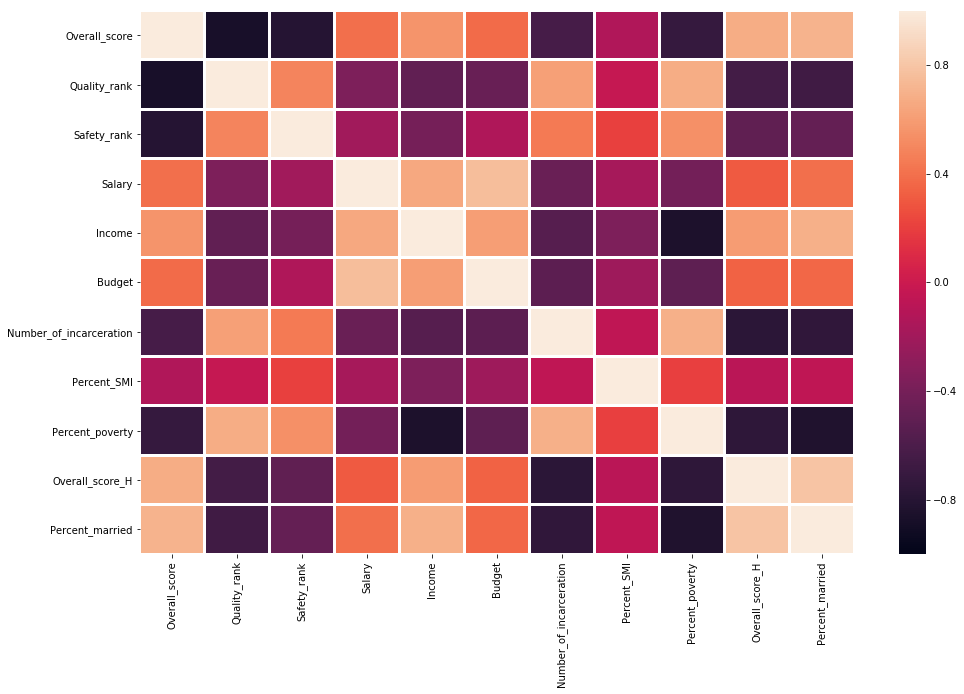

In [64]:
plt.figure(figsize = (16,10))

ax = sns.heatmap(result13.corr(),vmin=-1,vmax=1,linewidths=2,fmt="d")

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

# Verify our versions
import matplotlib